In [1]:
import mne
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression

# from mne.datasets import sample
from mne.decoding import LinearModel, GeneralizingEstimator
# from mne.decoding import cross_val_multiscore, LinearModel, GeneralizingEstimator, Scaler, \
#                          Vectorizer
# from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedShuffleSplit, \
#                                     RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder ,StandardScaler
# from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [2]:
# SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/' #my laptop
SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/' #eCortex
filename_epoch = SAVE_EPOCH_ROOT +  'epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif'

#Read Epochs
epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True, verbose=None)
epochs = epochs_orig.copy()
subset = epochs['pred']['non'].copy()
subset = subset.pick_types(eeg=True)
subset.crop(tmin=-0.4,tmax=0.5)

Reading ../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<EpochsFIF  |   876 events (all good), -0.4 - 0.5 sec, baseline [-0.4, 0], ~195.1 MB, data loaded, with metadata,
 'pred/down/non': 216
 'pred/left/non': 224
 'pred/right/non': 219
 'pred/up/non': 217>

In [3]:
# # SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/' #my laptop
# SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/' #eCortex
# filename_epoch = SAVE_EPOCH_ROOT +  'epochs_sec_applyBaseline_subj20-afterRejICA-epo.fif'

# #Read Epochs
# epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True, verbose=None)
# epochs = epochs_orig.copy()
# subset = epochs['pred']['non'].copy()
# subset = subset.pick_types(eeg=True)
# subset.crop(tmin=-0.4,tmax=0.5)

In [4]:
# print(subset.metadata.Ptrn_Type)

## Some preprocessing

In [5]:
if subset['Block==6'].metadata.Ptrn_Type.values.shape[0]>0:
       main_ptrn = subset['Block==6'].metadata.Ptrn_Type.values[0]
else:
       main_ptrn = subset['Block==8'].metadata.Ptrn_Type.values[0]

# only early blocks
subset = subset['Block<7'].copy()
subset = subset['Block>2'].copy()

# Group data based on the previous trial
Grp1 = subset['Trgt_Loc_prev==1'].copy() # right up
Grp2 = subset['Trgt_Loc_prev==2'].copy() # down right (wrong: 1 left)
Grp3 = subset['Trgt_Loc_prev==3'].copy() # down left
Grp4 = subset['Trgt_Loc_prev==4'].copy() # left up

Grp1._data = (Grp1._data - np.mean(Grp1._data)) / np.std(Grp1._data)
Grp2._data = (Grp2._data - np.mean(Grp2._data)) / np.std(Grp2._data)
Grp3._data = (Grp3._data - np.mean(Grp3._data)) / np.std(Grp3._data)
Grp4._data = (Grp4._data - np.mean(Grp4._data)) / np.std(Grp4._data)

In [6]:
print(Grp1)
print(Grp2)
print(Grp3)
print(Grp4)

<EpochsFIF  |   80 events (all good), -0.4 - 0.5 sec, baseline [-0.4, 0], ~18.0 MB, data loaded, with metadata,
 'pred/right/non': 39
 'pred/up/non': 41>
<EpochsFIF  |   87 events (all good), -0.4 - 0.5 sec, baseline [-0.4, 0], ~19.6 MB, data loaded, with metadata,
 'pred/down/non': 40
 'pred/left/non': 1
 'pred/right/non': 46>
<EpochsFIF  |   92 events (all good), -0.4 - 0.5 sec, baseline [-0.4, 0], ~20.7 MB, data loaded, with metadata,
 'pred/down/non': 44
 'pred/left/non': 48>
<EpochsFIF  |   93 events (all good), -0.4 - 0.5 sec, baseline [-0.4, 0], ~20.9 MB, data loaded, with metadata,
 'pred/left/non': 44
 'pred/up/non': 49>


# Plot

In [8]:
def set_fonts():
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Calibri')
    return font

In [9]:
def do_time_bin(data, indx, sbt):
    if sbt==0:
        avgs=np.zeros(len(indx))
        bs=np.array(np.split(data, indx))
        for ii in range(len(indx)):
            avgs[ii]=bs[ii].mean()
    if sbt==1:
         avgs=np.zeros([data.shape[0],len(indx)])
         aa=np.zeros(len(indx))
         for jj in range(data.shape[0]):
             bs=np.array(np.split(data[jj,:], indx))
             for ii in range(len(indx)):
                 aa[ii]=bs[ii].mean()
             avgs[jj,:]=aa
    if sbt==2:
         avgs=np.zeros([len(indx),len(indx)])
         aa=np.zeros(len(indx))
         for jj in range(data.shape[0]):
             bs1=np.array(np.split(data[jj,:], indx))
             bs2=np.array(np.split(data[:,jj], indx))
             for ii in range(len(indx)):
                 avgs[ii,:]=bs1[ii].mean()
                 avgs[:,ii]=bs2[ii].mean()

    return avgs

In [10]:
def smooth(y, window, mode):
    box = np.ones(window)/window
    y_smooth = np.convolve(y, box, mode=mode)
    return y_smooth

def plot_scores(scores, vmin, vmax):
    fig, ax = plt.subplots(1, 1)
    plt.tight_layout()
    im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=vmin, vmax=vmax)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('Temporal generalization')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def plot_scores_diag(scores_diag, apply_smooth):
    if apply_smooth:
        window=50
        mode='valid'
        scores_diag = smooth(y, window, mode)
        print(subset.times.shape)
        print(y_smooth.shape)
    fig, ax = plt.subplots()
    ax.plot(subset.times, scores_diag, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Sensor space decoding')
    plt.tight_layout()
    plt.show()

In [11]:
def plot_allConds_scores(title, sc_G1, sc_G2, sc_G3, sc_G4, vmin, vmax):

    font=set_fonts()
    fsize_t=30
    fsize_x=26
    
    if main_ptrn==1:
        title_G1 = 'G1 - up right'
        title_G2 = 'G2 - down right'
        title_G3 = 'G3 - down left'
        title_G4 = 'G4 - left up'
    elif main_ptrn==2:
        title_G1 = 'G1 - down right'
        title_G2 = 'G2 - down left'
        title_G3 = 'G3 - left up'
        title_G4 = 'G4 - right up'
            
    
    # Temp Gen Matrix ==========================================================================
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    ax = axs[0][0]
    im = ax.imshow(sc_G1[0], interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=vmin, vmax=vmax)
    ax.set_ylabel('Training Time (s)', fontproperties=font, fontsize=fsize_x, fontweight='bold')
    ax.set_title(title_G1, fontproperties=font, fontsize=fsize_t, fontweight='bold')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    plt.colorbar(im, ax=ax)
    ax.xaxis.set_ticks_position('bottom')
    
    ax = axs[0][1]
    im = ax.imshow(sc_G2[0], interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=vmin, vmax=vmax)
    ax.set_title(title_G2, fontproperties=font, fontsize=fsize_t, fontweight='bold')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    plt.colorbar(im, ax=ax)
    ax.xaxis.set_ticks_position('bottom')
    
    ax = axs[1][0]
    im = ax.imshow(sc_G3[0], interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=vmin, vmax=vmax)
    ax.set_xlabel('Testing Time (s)', fontproperties=font, fontsize=fsize_x, fontweight='bold')
    ax.set_ylabel('Training Time (s)', fontproperties=font, fontsize=fsize_x, fontweight='bold')
    ax.set_title(title_G3, fontproperties=font, fontsize=fsize_t, fontweight='bold')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    plt.colorbar(im, ax=ax)
    ax.xaxis.set_ticks_position('bottom')
    
    ax = axs[1][1]
    im = ax.imshow(sc_G4[0], interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=vmin, vmax=vmax)
    ax.set_xlabel('Testing Time (s)', fontproperties=font, fontsize=fsize_x, fontweight='bold')
    ax.set_title(title_G4, fontproperties=font, fontsize=fsize_t, fontweight='bold')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.suptitle(title, fontproperties=font, fontsize=fsize_t, fontweight='bold',  y=1.05)
    plt.tight_layout()


    # Temp Gen diagonal ==========================================================================
    indx=[0, 13, 26, 39, 52, 65, 78, 91, 107, 117, 130, 143, 156, 169, 182, 195, 208, 221, 225]
    sbt=0
    smooth_time = subset.times.copy()
    smooth_time = smooth_time[indx]

    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    
    smooth_G1=do_time_bin(sc_G1[1], indx, sbt)    
    ax = axs[0][0]
    ax.plot(smooth_time, smooth_G1, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_ylabel('AUC')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('G1', fontproperties=font, fontsize=fsize_t, fontweight='bold')
    plt.tight_layout()
    
    smooth_G2=do_time_bin(sc_G2[1], indx, sbt)    
    ax = axs[1][0]
    ax.plot(smooth_time, smooth_G2, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('G2', fontproperties=font, fontsize=fsize_t, fontweight='bold')
    plt.tight_layout()

    smooth_G3=do_time_bin(sc_G3[1], indx, sbt) 
    ax = axs[0][1]
    ax.plot(smooth_time, smooth_G3, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('G3', fontproperties=font, fontsize=fsize_t, fontweight='bold')
    plt.tight_layout()
    
    smooth_G4=do_time_bin(sc_G4[1], indx, sbt) 
    ax = axs[1][1]
    ax.plot(smooth_time, smooth_G4, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('G4', fontproperties=font, fontsize=fsize_t, fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle(title, fontproperties=font, fontsize=fsize_t, fontweight='bold',  y=1.05)
    plt.tight_layout()

    plt.show()

In [ ]:
# https://stackoverflow.com/questions/30143417/computing-the-correlation-coefficient-between-two-multi-dimensional-arrays
def generate_correlation_map(x, y):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])

(80, 129, 904)
x (129, 904)
y (904, 129)
mu_x (904,)
xmm (904, 129)
(904, 904)
(904, 904)
0.0


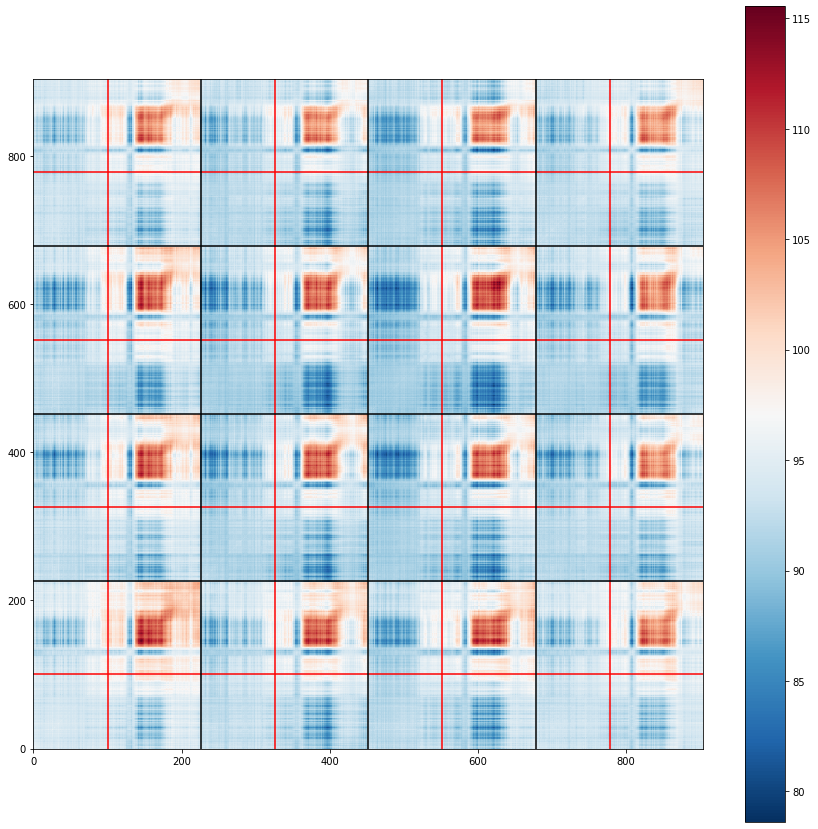

In [128]:
# https://stackoverflow.com/questions/30143417/computing-the-correlation-coefficient-between-two-multi-dimensional-arrays
# def generate_correlation_map(x, y):
"""Correlate each n with each m.

Parameters
----------
x : np.array
  Shape N X T.

y : np.array
  Shape M X T.

Returns
-------
np.array
  N X M array in which each element is a correlation coefficient.

"""
dt = np.mean(all_Grps2, axis=0) #avg over channels
print(all_Grps2.shape)

x=dt
y=np.transpose(x)
print('x', x.shape)
print('y', y.shape)

mu_x = x.mean(0)
# mu_y = y.mean(1)
print('mu_x', mu_x.shape)
# print('mu_y', mu_y.shape)

s_x = x.std(0)
# s_y = y.std(1)

# xmm = x[]-mu_x[:,np.newaxis]
xmm = y-mu_x[:,np.newaxis]
print('xmm', xmm.shape)
# ymm = y-mu_y[:,np.newaxis]


cov = np.dot(xmm,
             xmm.T)
print(cov.shape)
map_r= cov / np.sqrt(np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :]))
print(map_r.shape)



fig, ax = plt.subplots(1,1, figsize=[15,15])
im = ax.imshow(map_r, origin='lower', cmap='RdBu_r')#, extent=subset.times[[0, -1, 0 , -1]])

ax.axvline(100, color='r')
ax.axhline(100, color='r')

ax.axvline(100+226, color='r')
ax.axhline(100+226, color='r')

ax.axvline(100+226*2, color='r')
ax.axhline(100+226*2, color='r')

ax.axvline(100+226*3, color='r')
ax.axhline(100+226*3, color='r')

ax.axvline(226, color='k')
ax.axhline(226, color='k')

ax.axvline(226*2, color='k')
ax.axhline(226*2, color='k')

ax.axvline(226*3, color='k')
ax.axhline(226*3, color='k')

print(subset.times[100])
plt.colorbar(im, ax=ax)
# print(subset.times)

# dt = np.mean(all_Grps2, axis=1) #avg over channels
# x1 = np.transpose(dt)
# print('be')
# map_r2=generate_correlation_map(x1, x1)
# print(map_r2.shape)
# # fig, ax = plt.subplots(1,1, figsize=[15,15])
# # ax.imshow(map_r2, origin='lower', cmap='RdBu_r')#, extent=subset.times[[0, -1, 0 , -1]])
# # 

(80, 129, 904)
x (129, 904)
y (904, 129)
mu_x (904,)
xmm (904, 129)
(904, 904)
0.0


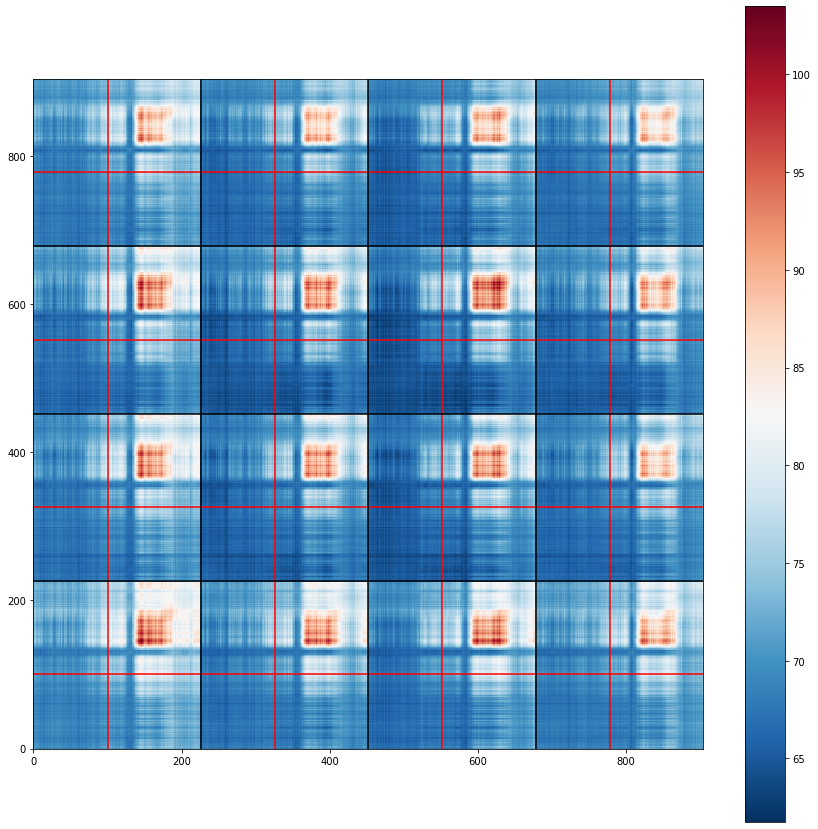

In [125]:
## only dot product without normalization
dt = np.mean(all_Grps2, axis=0) #avg over channels
print(all_Grps2.shape)

x=dt
y=np.transpose(x)
print('x', x.shape)
print('y', y.shape)

mu_x = x.mean(0)
# mu_y = y.mean(1)
print('mu_x', mu_x.shape)
# print('mu_y', mu_y.shape)

s_x = x.std(0)
# s_y = y.std(1)

# xmm = x[]-mu_x[:,np.newaxis]
xmm = y-mu_x[:,np.newaxis]
print('xmm', xmm.shape)
# ymm = y-mu_y[:,np.newaxis]


cov = np.dot(xmm,
             xmm.T)
cov2 = np.dot(y, dt)
# print(cov.shape)
# map_r= cov / np.sqrt(np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :]))

map_r=cov2
print(map_r.shape)

fig, ax = plt.subplots(1,1, figsize=[15,15])
im=ax.imshow(map_r, origin='lower', cmap='RdBu_r')#, extent=subset.times[[0, -1, 0 , -1]])

ax.axvline(100, color='r')
ax.axhline(100, color='r')

ax.axvline(100+226, color='r')
ax.axhline(100+226, color='r')

ax.axvline(100+226*2, color='r')
ax.axhline(100+226*2, color='r')

ax.axvline(100+226*3, color='r')
ax.axhline(100+226*3, color='r')

ax.axvline(226, color='k')
ax.axhline(226, color='k')

ax.axvline(226*2, color='k')
ax.axhline(226*2, color='k')

ax.axvline(226*3, color='k')
ax.axhline(226*3, color='k')

print(subset.times[100])
plt.colorbar(im, ax=ax)
plt.show()
# print(subset.times)

# dt = np.mean(all_Grps2, axis=1) #avg over channels
# x1 = np.transpose(dt)
# print('be')
# map_r2=generate_correlation_map(x1, x1)
# print(map_r2.shape)
# # fig, ax = plt.subplots(1,1, figsize=[15,15])
# # ax.imshow(map_r2, origin='lower', cmap='RdBu_r')#, extent=subset.times[[0, -1, 0 , -1]])
# # 

# apply decoder

In [12]:
le = LabelEncoder()
clf_SVC  = make_pipeline(
                        StandardScaler(),
                        LinearModel(LinearSVC(random_state=0, max_iter=10000)))
time_gen = GeneralizingEstimator(clf_SVC, scoring='roc_auc', n_jobs=1,verbose=True)

## test on Grp2

In [11]:
# ........................................................#
# ...................... train on Grp 1 ...................#
# ........................................................#

Grp_data = Grp1
X=Grp_data.copy()._data
y=le.fit_transform(Grp_data.copy().metadata.Trgt_Loc_main)

time_gen.fit(X=X ,y=y)
score1 = time_gen.score(X=X, y=y) #scores without cv
score_diag1 = np.diag(score1)
scores1 = (score1.copy(), score_diag1.copy())

# ........................................................#
# ...................... test on Grp 2 ...................#
# ........................................................#
X2=Grp2.copy()._data
y2=le.fit_transform(Grp2.copy().metadata.Trgt_Loc_main)


if (np.unique(y2).shape[0] == 3):
    print(y2.shape)
    print(X2.shape)
    X2 = X2[y2!=0,:,:]
    y2 = y2[y2!=0]
    print(y2.shape)
    print(X2.shape)
    
score2 = time_gen.score(X=X2, y=y2) #scores without cv
score_diag2 = np.diag(score2)
scores2 = (score2.copy(), score_diag2.copy())

# ........................................................#
# ...................... test on Grp 3 ...................#
# ........................................................#
X3=Grp3.copy()._data
y3=le.fit_transform(Grp3.copy().metadata.Trgt_Loc_main)
print(np.unique(y3))

score3 = time_gen.score(X=X2, y=y2) #scores without cv
score_diag3 = np.diag(score3)
scores3 = (score3.copy(), score_diag3.copy())

# ........................................................#
# ...................... test on Grp 4 ...................#
# ........................................................#
X4=Grp4.copy()._data
y4=le.fit_transform(Grp4.copy().metadata.Trgt_Loc_main)
print(np.unique(y4))

score4 = time_gen.score(X=X4, y=y4) #scores without cv
score_diag4 = np.diag(score4)
scores4 = (score4.copy(), score_diag4.copy())

[........................................] 100.00% Fitting GeneralizingEstimato
[........................................] 100.00% Scoring GeneralizingEstimato
[........................................] 100.00% Scoring GeneralizingEstimato
[0 1]
[........................................] 100.00% Scoring GeneralizingEstimato
[0 1]
[........................................] 100.00% Scoring GeneralizingEstimato


#### Lets go into more details of what is going on 
concatanate them all groups and repeat the decoding 

In [ ]:
print(Grp1._data.shape)
# n_samples: 88
# n_features: 129
# n_tasks = 226
print(Grp1.metadata.Trgt_Loc_main.shape)
# n_samples: 88

#return fit_transform:
# n_samples X n_tasks = 88 X 226
# for each task (time) a clone estimator is fitted independently. 
# y_pred: the predicted values for each estimator
# estimator: shape : n_tasks; list of fitted scikit-learn estimators (per task)

In [13]:
Grp_data = Grp1
X_o=Grp_data.copy()._data
y=le.fit_transform(Grp_data.copy().metadata.Trgt_Loc_main)

aa=time_gen.fit(X=X_o ,y=y)
score_aa = time_gen.score(X=X_o, y=y) #scores without cv

[........................................] 100.00% Fitting GeneralizingEstimato
[........................................] 100.00% Scoring GeneralizingEstimato


In [15]:
Grp_data = Grp1
X_o=Grp_data.copy()._data
X_r=X_o.copy().reshape(X_o.shape[0],X_o.shape[2],X_o.shape[1])
y=le.fit_transform(Grp_data.copy().metadata.Trgt_Loc_main)

bb=time_gen.fit(X=X_r ,y=y)
score_bb = time_gen.score(X=X_r, y=y) #scores without cv

score_diag_bb = np.diag(score_bb)
scores_bb = (score_bb.copy(), score_diag_bb.copy())


[........................................] 100.00% Fitting GeneralizingEstimato
[........................................] 100.00% Scoring GeneralizingEstimato


all:  (355, 129, 226)
1:  (80, 129, 226)
2:  (87, 129, 226)
3:  (92, 129, 226)
4:  (93, 129, 226)
(80, 129, 226)
(87, 129, 226)
(92, 129, 226)
(93, 129, 226)
(352, 129, 226)


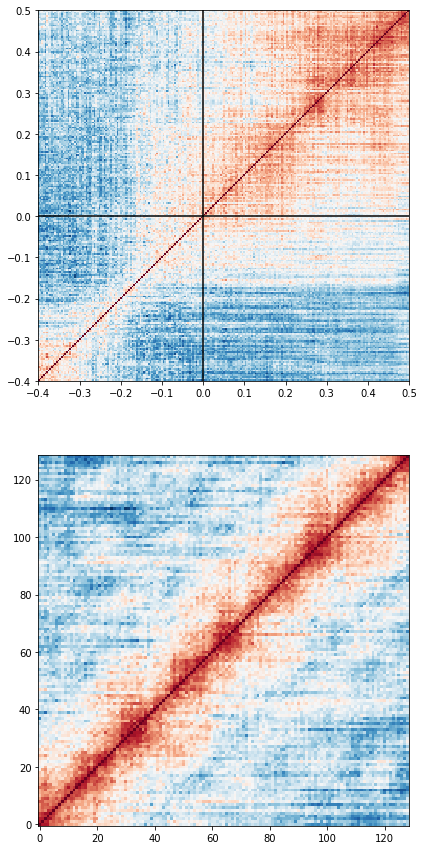

In [63]:
score_diag_bb = np.diag(score_bb)
scores_bb = (score_bb.copy(), score_diag_bb.copy())

score_diag_aa = np.diag(score_aa)
scores_aa = (score_aa.copy(), score_diag_aa.copy())

fig, ax = plt.subplots(2,1, figsize=[15,15])
ax[0].imshow(score_aa, origin='lower', cmap='RdBu_r', extent=subset.times[[0, -1, 0 , -1]])
ax[0].axvline(0, color='k')
ax[0].axhline(0, color='k')
ax[0].xaxis.set_ticks_position('bottom')

ax[1].imshow(score_bb, origin='lower', cmap='RdBu_r')
ax[1].xaxis.set_ticks_position('bottom')

g1s=Grp1._data.shape[0]
g2s=Grp2._data.shape[0]
g3s=Grp3._data.shape[0]
g4s=Grp4._data.shape[0]


all_Grps = np.zeros([g1s+g2s+g3s+g4s+3, Grp1._data.shape[1], Grp1._data.shape[2]])
print('all: ',all_Grps.shape)
print('1: ', all_Grps[0:g1s,:,:].shape)
print('2: ', all_Grps[g1s+1:g1s+g2s+1,:,:].shape)
print('3: ', all_Grps[g1s+g2s+2:g1s+g2s+g3s+2,:,:].shape)
print('4: ', all_Grps[g1s+g2s+g3s+3:g1s+g2s+g3s+g4s+3,:,:].shape)

all_Grps[0:g1s,:,:] = Grp1._data
all_Grps[g1s+1:g1s+g2s+1,:,:] = Grp2._data
all_Grps[g1s+g2s+2:g1s+g2s+g3s+2,:,:] = Grp3._data
all_Grps[g1s+g2s+g3s+3:g1s+g2s+g3s+g4s+3,:,:] = Grp4._data

print(Grp1._data.shape)
print(Grp2._data.shape)
print(Grp3._data.shape)
print(Grp4._data.shape)



In [77]:
min_d = np.min((g1s, g2s, g3s, g4s))
all_Grps2=np.concatenate((Grp1._data[0:min_d,:,:], Grp2._data[0:min_d,:,:], \
                          Grp3._data[0:min_d,:,:], Grp4._data[0:min_d,:,:]), axis=-1)
print(min_d, all_Grps2.shape)


80 (80, 129, 904)


In [78]:
dt = np.mean(all_Grps2, axis=0) #avg over channels
x1 = np.transpose(dt)
map_r = generate_correlation_map(x1, x1)
print(map_r.shape)

ValueError: operands could not be broadcast together with shapes (904,904) (129,129) 

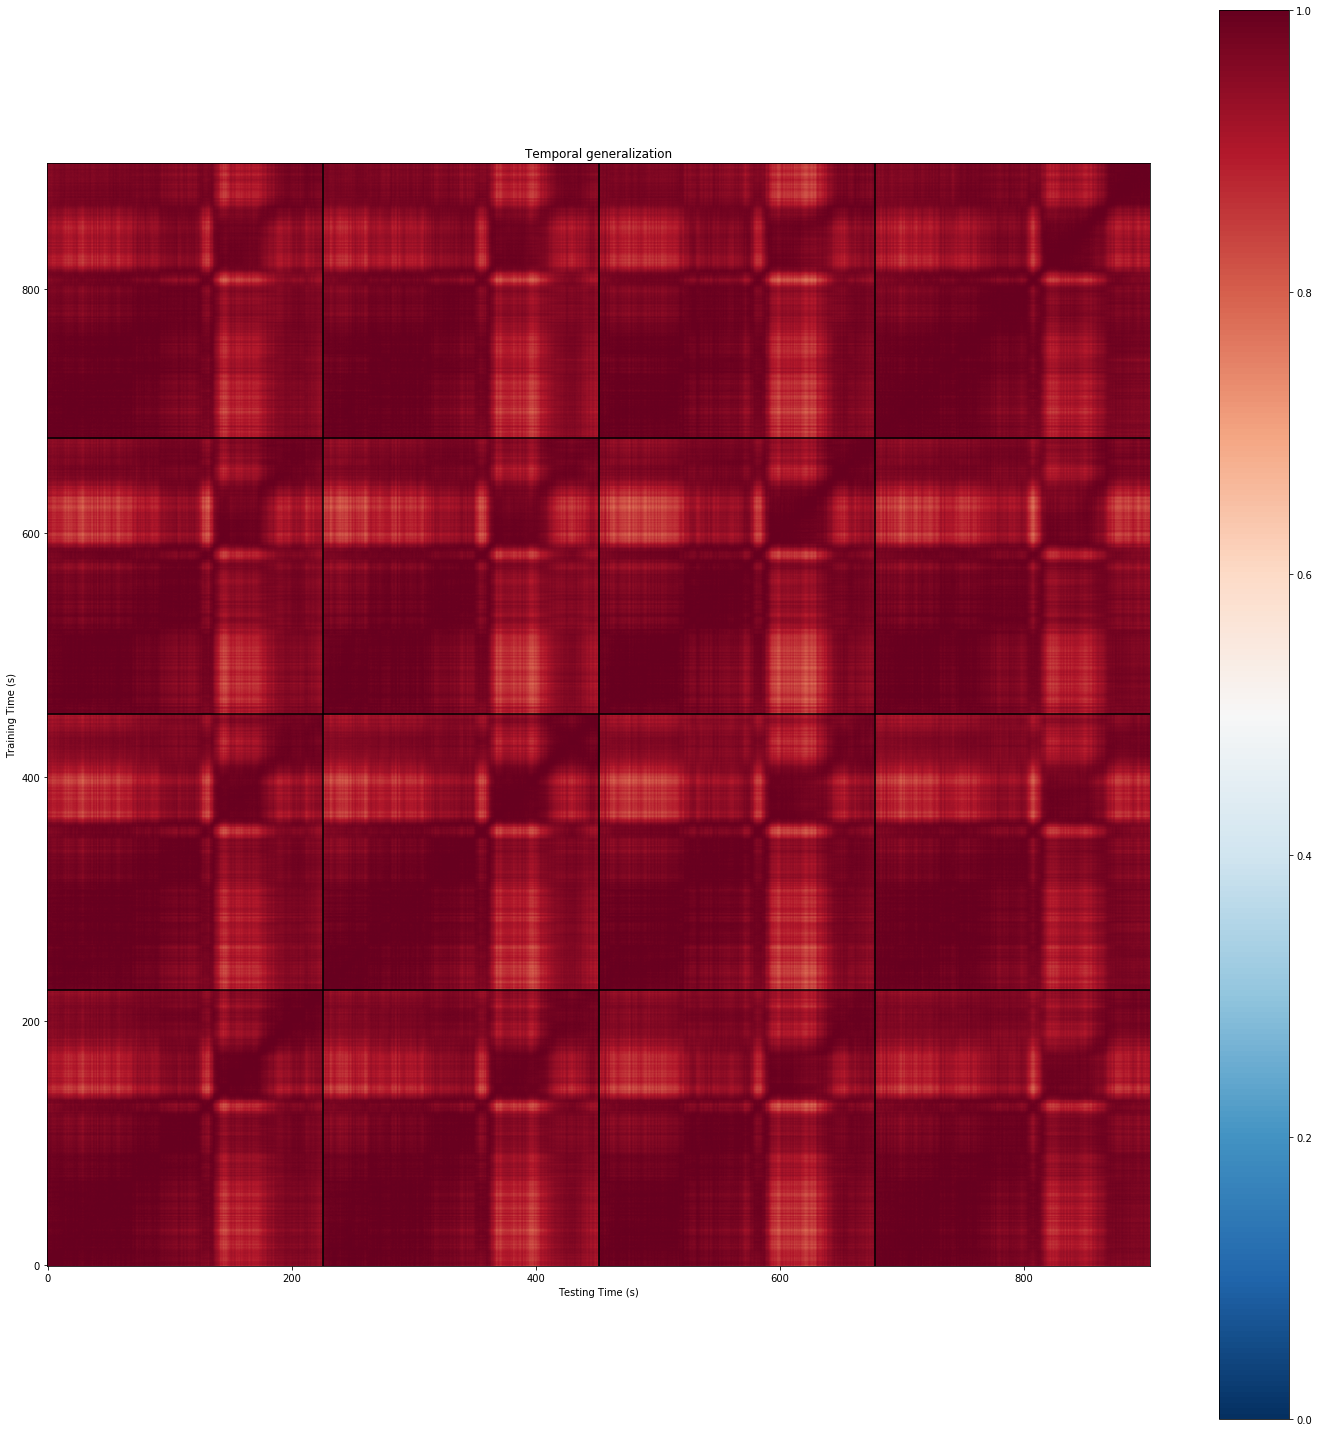

In [75]:
# 0:g1s,:,:] = Grp1._data
# all_Grps[g1s+1:g1s+g2s+1,:,:] = Grp2._data
# all_Grps[g1s+g2s+2:g1s+g2s+g3s+2,:,:] = Grp3._data
# all_Grps[g1s+g2s+g3s+3:g1s+g2s+g3s+g4s+3,:,:] = Grp4._data

fig, ax = plt.subplots(1, 1, figsize=(20,20))
plt.tight_layout()
im = ax.imshow(map_r, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               vmin=0, vmax=1) #extent=epochs.times[[0, -1, 0 , -1]]
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')

ax.axvline(226, color='k')
ax.axhline(226, color='k')

ax.axvline(226*2, color='k')
ax.axhline(226*2, color='k')

ax.axvline(226*3, color='k')
ax.axhline(226*3, color='k')


ax.xaxis.set_ticks_position('bottom')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# plot all of them

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
/home/mazlfghr/.conda/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/home/mazlfghr/.conda/envs/DeepLearningEEG/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


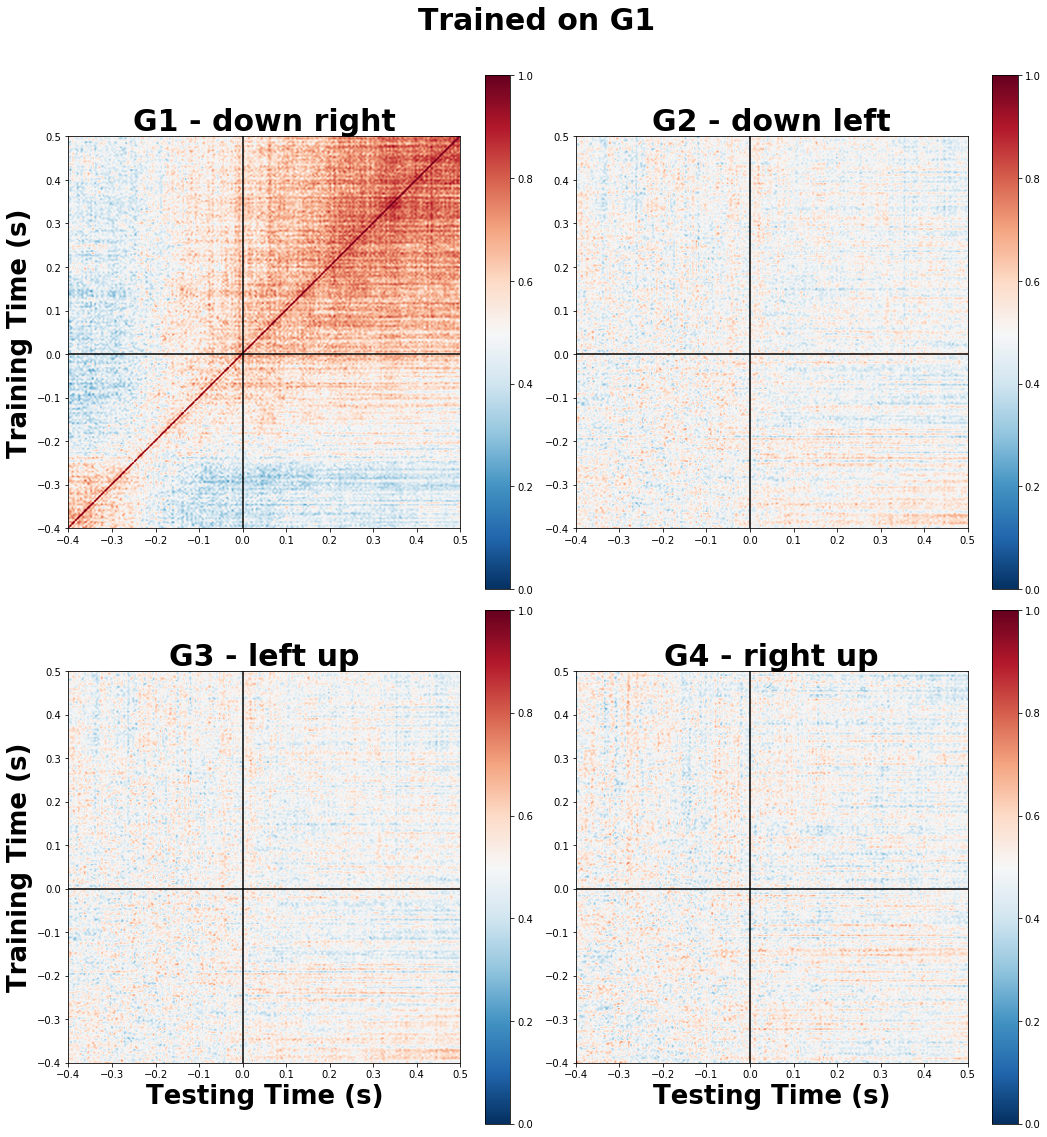

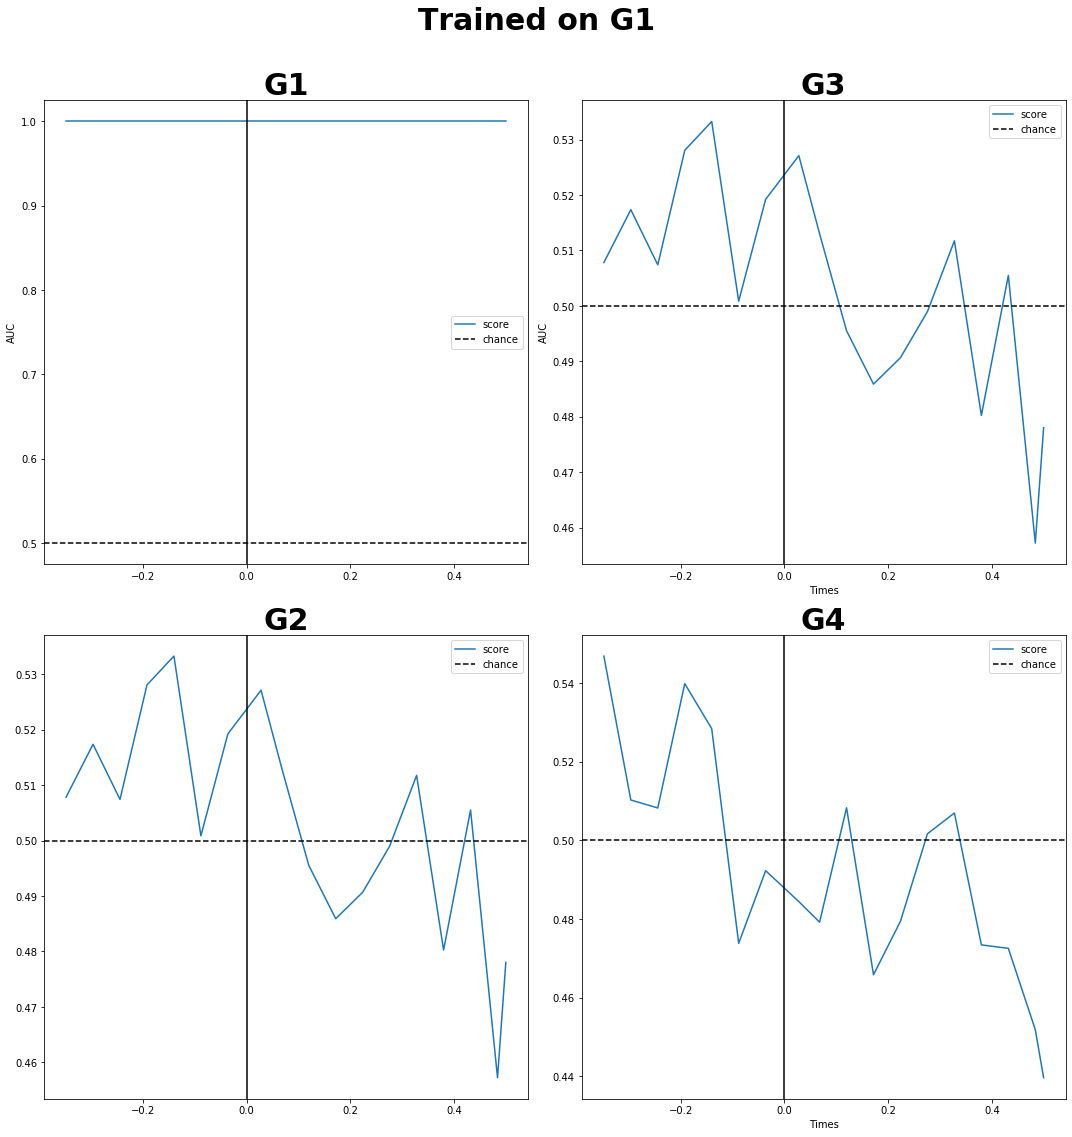

In [22]:
title='Trained on G1'
plot_allConds_scores(title, scores1, scores2, scores3, scores4, vmin=0, vmax=1)

In [ ]:
le = LabelEncoder()
clf_SVC  = make_pipeline(
                        StandardScaler(),
                        LinearModel(LinearSVC(random_state=0, max_iter=10000)))
time_gen = GeneralizingEstimator(clf_SVC, scoring='roc_auc', n_jobs=1,verbose=True)

train_data = Grp1
X_tr=train_data.copy()._data
y_tr=le.fit_transform(train_data.copy().metadata.Trgt_Loc_main)

print(X_tr.shape)
print(y_tr.shape)

for ttr in range(subset.times):
    X_ttr=X_tr[:,:,ttr]
    time_gen.fit(X=X_ttr ,y=y_tr)
    for tte in range(subset.times):
        
    



score1 = time_gen.score(X=X, y=y) #scores without cv
score_diag1 = np.diag(score1)
scores1 = (score1.copy(), score_diag1.copy())


X3=Grp3.copy()._data
y3=le.fit_transform(Grp3.copy().metadata.Trgt_Loc_main)
print(np.unique(y3))

score3 = time_gen.score(X=X2, y=y2) #scores without cv
score_diag3 = np.diag(score3)
scores3 = (score3.copy(), score_diag3.copy())